In [1]:
import math, random, sys
sys.path.insert(0, '/workspace/icml18-jtnn_original')

In [112]:
from copy import copy

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

In [107]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm import tqdm
import numpy as np
from CGRtools import smiles
from optparse import OptionParser
from collections import deque
from IPython.display import clear_output

from jtnn import *
import rdkit

    
lg = rdkit.RDLogger.logger() 
lg.setLevel(rdkit.RDLogger.CRITICAL)

In [4]:
from warnings import filterwarnings
filterwarnings("ignore")

In [5]:
def get_mae_loss(x, y):
    return np.mean(np.abs(x - y))

def get_mse_loss(x, y):
    return np.mean((x - y)**2)

In [6]:
vocab_path = "./data/qdb9/prunned/vocab.txt"
vocab = [x.strip("\r\n ") for x in open(vocab_path)] 
vocab = Vocab(vocab)

In [82]:
batch_size = 128
hidden_size = 450
latent_size = 256
depth = 3
stereo = True
modelvae_path = 'vae_model/qdb9_zinc_prunned_256/model'

model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
model.load_state_dict(torch.load(modelvae_path))
model = model.cuda()

model.eval()

regressor = RandomForestRegressor(warm_start=True)

In [ ]:
mol1 = smiles(dec_smiles)
mol1.clean_stereo()
mol1.canonicalize()

## Validity test

In [108]:
cset = set()

with open("data/qdb9/all.txt", "r") as file:
    lines = set([smiles(x.strip("\n")) for x in file.readlines()])

In [132]:
smile = model.sample_prior()
print(smile)

C[C@@H]1OC[C@@H]1C=O


In [118]:
false = 0
size = 10000
pbar = tqdm(range(10000))

for i, j in enumerate(pbar):
    smile = model.sample_prior()
    if smile == None:
        false += 1
    elif smiles(smile) in lines:
        false += 1

    pbar.set_description("Current element %i/%i intrain molecules: %i , score: %f" % (i, size, false, (1 - false/(i+1))))

Current element 9999/10000 intrain molecules: 507 , score: 0.949300: 100%|██████████| 10000/10000 [46:07<00:00,  3.61it/s] 


In [9]:
columns = ["tree", "target"]
df_train = pd.DataFrame(columns=columns)
df_test = pd.DataFrame(columns=columns)

In [170]:
homo_path = "./data/qdb9/prunned/qdb9/train_homo.txt"
homo_data = []

with open(homo_path, "r") as file:
    homo_data.extend([float(x.strip("\n")) for x in file.readlines()])

In [171]:
lumo_path = "./data/qdb9/prunned/qdb9/train_lumo.txt"
lumo_data = []

with open(lumo_path, "r") as file:
    lumo_data.extend([float(x.strip("\n")) for x in file.readlines()])

In [10]:
test_path = "./data/qdb9/prunned/qdb9/test_smiles.txt"
test_prop_path = "./data/qdb9/prunned/qdb9/test_lumo.txt"
test_data = PropDataset(test_path, test_prop_path)

train_path = "./data/qdb9/prunned/qdb9/train_smiles.txt"
train_prop_path = "./data/qdb9/prunned/qdb9/train_lumo.txt"
train_data = PropDataset(train_path, train_prop_path)

test = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x:x, drop_last=False)
train = DataLoader(train_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x:x, drop_last=False)

In [ ]:
size = len(train)
pbar = tqdm(train)

for batch in pbar:
    X, y = zip(*batch)
    piece = np.concatenate([np.array(X)[:, None], np.array(y)[:, None]], axis=1)
    df_train = df_train.append(pd.DataFrame(piece, columns = columns), ignore_index=True)

  6%|▋         | 52/819 [27:29<6:36:09, 30.99s/it]

In [16]:
size = len(test)
pbar = tqdm(test)

for batch in pbar:
    X, y = zip(*batch)
    piece = np.concatenate([np.array(X)[:, None], np.array(y)[:, None]], axis=1)
    df_test = df_test.append(pd.DataFrame(piece, columns = columns), ignore_index=True)

100%|██████████| 39/39 [21:38<00:00, 33.31s/it]


In [17]:
X = pd.DataFrame(columns=[str(x) for x in range(latent_size)])
y = []

In [18]:
#TESTING
with torch.no_grad():
    size = df_train.shape[0]//batch_size
    pbar = tqdm(range(df_train.shape[0]//batch_size))
    for i in pbar:
        features = model.get_embeddings(list(df_train[batch_size*i: batch_size*(i+1)]["tree"]))
        X = X.append(pd.DataFrame(features.cpu().numpy(), columns=X.columns),ignore_index=True)
        y.extend(df_train[batch_size*i: batch_size*(i+1)]["target"])

100%|██████████| 718/718 [03:20<00:00,  3.58it/s]


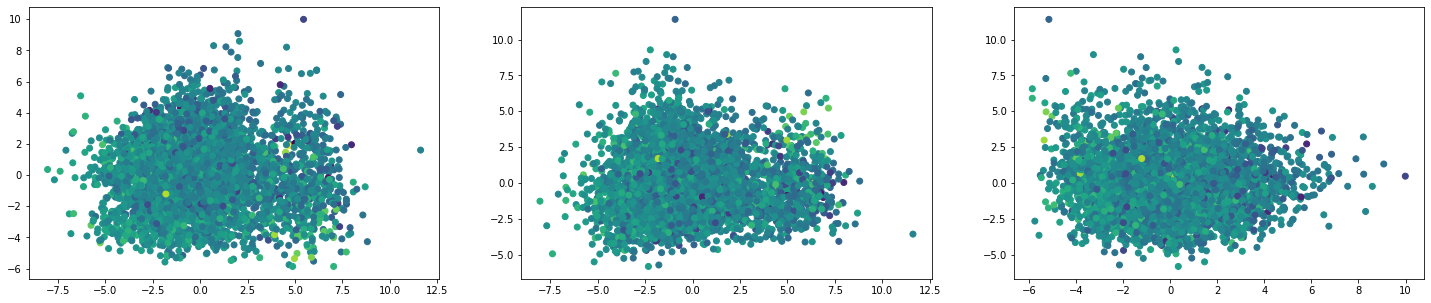

In [19]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(25, 5))
ax = plt.subplot(131)
ax.scatter(X_pca[::20, 0], X_pca[::20, 1], c = y[::20])

ax = plt.subplot(132)
ax.scatter(X_pca[::20, 0], X_pca[::20, 2], c = y[::20])

ax = plt.subplot(133)
ax.scatter(X_pca[::20, 1], X_pca[::20, 2], c = y[::20])
plt.show()

In [20]:
X_val = pd.DataFrame(columns=[str(x) for x in range(latent_size)])
y_val = []

In [21]:
#TESTING
with torch.no_grad():
    size = df_test.shape[0]//batch_size
    pbar = tqdm(range(df_test.shape[0]//batch_size))
    for i in pbar:
        features = model.get_embeddings(list(df_test[batch_size*i: batch_size*(i+1)]["tree"]))
        X_val = X_val.append(pd.DataFrame(features.cpu().numpy(), columns=X.columns),ignore_index=True)
        y_val.extend(df_test[batch_size*i: batch_size*(i+1)]["target"])

100%|██████████| 38/38 [00:10<00:00,  3.76it/s]


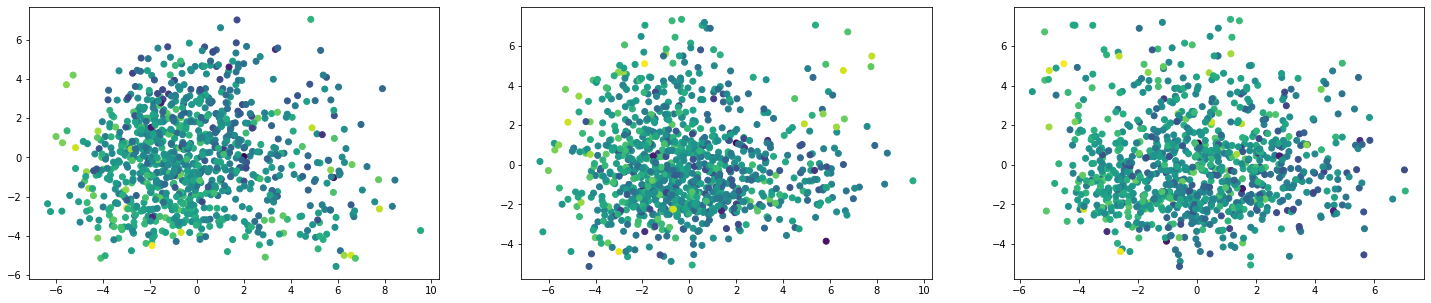

In [22]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_val)

plt.figure(figsize=(25, 5))
ax = plt.subplot(131)
ax.scatter(X_pca[::5, 0], X_pca[::5, 1], c = y_val[::5])

ax = plt.subplot(132)
ax.scatter(X_pca[::5, 0], X_pca[::5, 2], c = y_val[::5])

ax = plt.subplot(133)
ax.scatter(X_pca[::5, 1], X_pca[::5, 2], c = y_val[::5])
plt.show()

## Random Forest

In [77]:
rf_regressor = RandomForestRegressor(verbose=1, n_jobs=20, criterion="mae", n_estimators=1000, max_features='log2')
rf_regressor.fit(X, y)
y_prediction = rf_regressor.predict(X_val)
get_mae_loss(y_prediction, y_val)

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:  4.1min
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed: 37.5min
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed: 105.8min
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed: 197.1min
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed: 269.8min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.2953563690986842

## Elastic Net

In [26]:
rf_en = ElasticNet()
rf_en.fit(X, y)
y_prediction = rf_en.predict(X_val)
get_mae_loss(y_prediction, y_val)

0.37014354919363324

## Ridge regression

In [27]:
rf_ridge = Ridge()
rf_ridge.fit(X, y)
y_prediction = rf_ridge.predict(X_val)
get_mae_loss(y_prediction, y_val)

0.2780108083830382

## NNs

## LUMO Prediction

In [138]:
def train_model(dataset, model, regressor, fLoss, batch_size, optimizer, optimizer_reg, scheduler, scheduler_reg, epoch, df):
    model.train()
    regressor.train()
    mse = 0
    mae = 0
    size = dataset.shape[0]//batch_size
    pbar = tqdm(range(dataset.shape[0]//batch_size))
    
    for i in pbar:
        model.zero_grad()
        regressor.zero_grad()
        prop = np.array(dataset[batch_size*i: batch_size*(i+1)]["target"], dtype=float).squeeze()
        
        features = model.get_embeddings(list(dataset[batch_size*i: batch_size*(i+1)]["tree"]))
        prediction = regressor(features)

        wloss = fLoss(prediction, torch.cuda.FloatTensor(prop)[:, None])
        wloss.backward()

        optimizer.step()
        optimizer_reg.step()
        
        mse += float(wloss.item())
        
        mae += get_mae_loss(prediction.cpu().detach().numpy().squeeze(), prop)
        
    df = df.append(pd.Series([epoch, 
                              mse/size,
                              mae/size,
                              optimizer.param_groups[0]['lr'],
                              optimizer_reg.param_groups[0]['lr']], index=df.columns), ignore_index=True)

    scheduler.step(df.iloc[-1, 1])
    scheduler_reg.step(df.iloc[-1, 1])
    
    return df
        
def test_model(dataset, model, regressor, batch_size, epoch, df):
    with torch.no_grad():
        model.eval()
        regressor.eval()
        mse = 0
        mae = 0
        size = dataset.shape[0]//batch_size
        pbar = tqdm(range(dataset.shape[0]//batch_size))

        for i in pbar:
            prop = np.array(dataset[batch_size*i: batch_size*(i+1)]["target"], dtype=float).squeeze()

            features = model.get_embeddings(list(dataset[batch_size*i: batch_size*(i+1)]["tree"]))
            prediction = regressor(features)
            
            mse += get_mse_loss(prediction.cpu().detach().numpy().squeeze(), prop)

            mae += get_mae_loss(prediction.cpu().detach().numpy().squeeze(), prop)

        df = df.append(pd.Series([epoch, 
                                  mse/size,
                                  mae/size,], index=df.columns), ignore_index=True)

    return df


In [139]:
lr, lr_reg = 0.001, 0.01 

regressor = nn.Sequential(
    nn.Linear(latent_size, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
)

for param in regressor.parameters():
    if param.dim() == 1:
        nn.init.constant_(param, 0)
    else:
        nn.init.xavier_normal_(param)

modelvae_path = 'vae_model/qdb9_zinc_prunned_256/model'

model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
model.load_state_dict(torch.load(modelvae_path))


model = model.cuda()
regressor = regressor.cuda()

In [141]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.5, patience=3, min_lr=1e-6)

optimizer_reg = optim.Adam(regressor.parameters(), lr=lr_reg)
scheduler_reg = lr_scheduler.ReduceLROnPlateau(optimizer_reg, mode="min",factor=0.5, patience=3, min_lr=1e-6)

In [143]:
fLoss = nn.SmoothL1Loss(beta=0.1)
MAX_EPOCH = 10


train_verbose_df = pd.DataFrame(columns=["Step", "MSE Loss", "MAE Loss", "LR_enc", "LR_reg"])
test_verbose_df = pd.DataFrame(columns=["Step", "MSE Loss", "MAE Loss"])

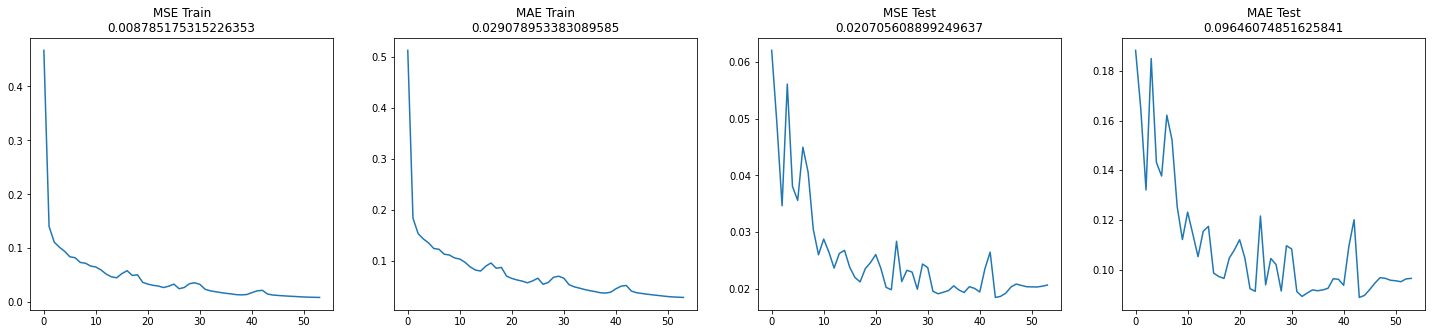

In [175]:
for epoch in range(50):
    
    train_verbose_df = train_model(df_train, model, regressor, fLoss, batch_size, optimizer, optimizer_reg, scheduler, scheduler_reg, epoch, train_verbose_df)
    test_verbose_df = test_model(df_test, model, regressor, batch_size, epoch, test_verbose_df)
    
    clear_output(True)
    
    plt.figure(figsize=(25, 5))

    ax = plt.subplot(141)
    ax.plot(train_verbose_df["MSE Loss"])
    ax.set_title("MSE Train\n{}".format(train_verbose_df["MSE Loss"].iloc[-1]))

    ax = plt.subplot(142)
    ax.plot(train_verbose_df["MAE Loss"])
    ax.set_title("MAE Train\n{}".format(train_verbose_df["MAE Loss"].iloc[-1]))

    ax = plt.subplot(143)
    ax.plot(test_verbose_df["MSE Loss"])
    ax.set_title("MSE Test\n{}".format(test_verbose_df["MSE Loss"].iloc[-1]))

    ax = plt.subplot(144)
    ax.plot(test_verbose_df["MAE Loss"])
    ax.set_title("MAE Test\n{}".format(test_verbose_df["MAE Loss"].iloc[-1]))
    plt.show()

In [81]:
torch.save(model.state_dict(), "reg_model/qdb9_zinc_prunned_256_lumo_2/model")
torch.save(regressor.state_dict(), "reg_model/qdb9_zinc_prunned_256_lumo_2/model_regression")

In [218]:
test_verbose_df_1024_1024_homo  = train_verbose_df
test_verbose_df_1024_1024_homo = test_verbose_df

In [217]:
test_verbose_df_256_128_homo = test_verbose_df_256_128
test_verbose_df_256_128_homo = test_verbose_df_256_128

## LUMO Prediction

In [220]:
with open(train_path) as f:
    data_smiles_train = [line.strip("\r\n ").split()[0] for line in f]

In [221]:
df_train_lumo = df_train
df_test_lumo = df_test

all_data = pd.read_csv("data/qdb9/prunned/qdb9/qdb9_prunned.csv", header=None)
all_data.columns = ["mol_id", "lumo", "homo", "smiles"]

In [240]:
lumo_data = []
homo_data = []

In [241]:
size = len(data_smiles_train)
pbar = tqdm(data_smiles_train)

for smile in pbar:
    slices = all_data[all_data.smiles == smile].iloc[0]
    lumo_data.append(slices.lumo)
    homo_data.append(slices.homo)

100%|██████████| 104832/104832 [22:56<00:00, 76.14it/s]


In [277]:
df_train_lumo.target = lumo_data[:df_train_homo.shape[0]]

In [278]:
with open(test_path) as f:
    data_smiles_test = [line.strip("\r\n ").split()[0] for line in f]

In [279]:
lumo_data = []
homo_data = []

In [280]:
size = len(data_smiles_test)
pbar = tqdm(data_smiles_test)

for smile in pbar:
    slices = all_data[all_data.smiles == smile].iloc[0]
    lumo_data.append(slices.lumo)
    homo_data.append(slices.homo)

100%|██████████| 4966/4966 [01:04<00:00, 76.98it/s]


In [283]:
df_test_lumo.target = lumo_data

In [284]:
all_data.columns = ["mol_id", "lumo", "homo", "smiles"]

In [295]:
lr, lr_reg = 0.001, 0.01 

regressor = nn.Sequential(
    nn.Linear(latent_size, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
)

for param in regressor.parameters():
    if param.dim() == 1:
        nn.init.constant_(param, 0)
    else:
        nn.init.xavier_normal_(param)

modelvae_path = 'vae_model/qdb9_zinc_prunned_256/model'

model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
model.load_state_dict(torch.load(modelvae_path))


model = model.cuda()
regressor = regressor.cuda()

In [296]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.5, patience=3, min_lr=1e-6)

optimizer_reg = optim.Adam(regressor.parameters(), lr=lr_reg)
scheduler_reg = lr_scheduler.ReduceLROnPlateau(optimizer_reg, mode="min",factor=0.5, patience=3, min_lr=1e-6)

In [297]:
fLoss = nn.SmoothL1Loss(beta=0.1)
MAX_EPOCH = 10


train_verbose_df = pd.DataFrame(columns=["Step", "MSE Loss", "MAE Loss", "LR_enc", "LR_reg"])
test_verbose_df = pd.DataFrame(columns=["Step", "MSE Loss", "MAE Loss"])

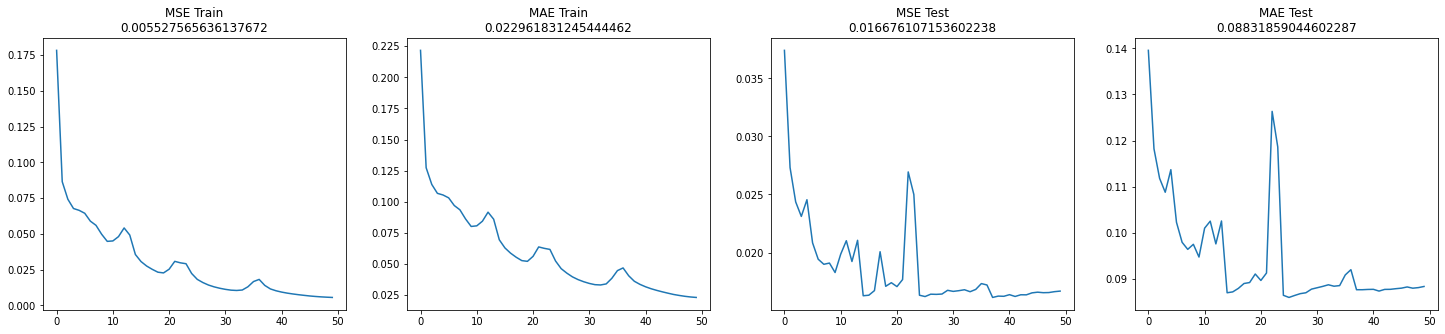

In [298]:
for epoch in range(50):
    
    train_verbose_df = train_model(df_train_lumo, model, regressor, fLoss, batch_size, optimizer, optimizer_reg, scheduler, scheduler_reg, epoch, train_verbose_df)
    test_verbose_df = test_model(df_test_lumo, model, regressor, batch_size, epoch, test_verbose_df)
    
    clear_output(True)
    
    plt.figure(figsize=(25, 5))

    ax = plt.subplot(141)
    ax.plot(train_verbose_df["MSE Loss"])
    ax.set_title("MSE Train\n{}".format(train_verbose_df["MSE Loss"].iloc[-1]))

    ax = plt.subplot(142)
    ax.plot(train_verbose_df["MAE Loss"])
    ax.set_title("MAE Train\n{}".format(train_verbose_df["MAE Loss"].iloc[-1]))

    ax = plt.subplot(143)
    ax.plot(test_verbose_df["MSE Loss"])
    ax.set_title("MSE Test\n{}".format(test_verbose_df["MSE Loss"].iloc[-1]))

    ax = plt.subplot(144)
    ax.plot(test_verbose_df["MAE Loss"])
    ax.set_title("MAE Test\n{}".format(test_verbose_df["MAE Loss"].iloc[-1]))
    plt.show()

## Less trained NNlr, lr_reg = 0.001, 0.01 

In [306]:
lr, lr_reg = 0.001, 0.01 

regressor = nn.Sequential(
    nn.Linear(latent_size, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
)

for param in regressor.parameters():
    if param.dim() == 1:
        nn.init.constant_(param, 0)
    else:
        nn.init.xavier_normal_(param)

modelvae_path = 'vae_model/qdb9_prunned_256/model'

model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
model.load_state_dict(torch.load(modelvae_path))


model = model.cuda()
regressor = regressor.cuda()

In [307]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.5, patience=3, min_lr=1e-6)

optimizer_reg = optim.Adam(regressor.parameters(), lr=lr_reg)
scheduler_reg = lr_scheduler.ReduceLROnPlateau(optimizer_reg, mode="min",factor=0.5, patience=3, min_lr=1e-6)

In [308]:
fLoss = nn.SmoothL1Loss(beta=0.1)
MAX_EPOCH = 10


train_verbose_df = pd.DataFrame(columns=["Step", "MSE Loss", "MAE Loss", "LR_enc", "LR_reg"])
test_verbose_df = pd.DataFrame(columns=["Step", "MSE Loss", "MAE Loss"])

In [ ]:
for epoch in range(50):
    
    train_verbose_df = train_model(df_train_lumo, model, regressor, fLoss, batch_size, optimizer, optimizer_reg, scheduler, scheduler_reg, epoch, train_verbose_df)
    test_verbose_df = test_model(df_test_lumo, model, regressor, batch_size, epoch, test_verbose_df)
    
    clear_output(True)
    
    plt.figure(figsize=(25, 5))

    ax = plt.subplot(141)
    ax.plot(train_verbose_df["MSE Loss"])
    ax.set_title("MSE Train\n{}".format(train_verbose_df["MSE Loss"].iloc[-1]))

    ax = plt.subplot(142)
    ax.plot(train_verbose_df["MAE Loss"])
    ax.set_title("MAE Train\n{}".format(train_verbose_df["MAE Loss"].iloc[-1]))

    ax = plt.subplot(143)
    ax.plot(test_verbose_df["MSE Loss"])
    ax.set_title("MSE Test\n{}".format(test_verbose_df["MSE Loss"].iloc[-1]))

    ax = plt.subplot(144)
    ax.plot(test_verbose_df["MAE Loss"])
    ax.set_title("MAE Test\n{}".format(test_verbose_df["MAE Loss"].iloc[-1]))
    plt.show()

 73%|███████▎  | 527/718 [02:18<00:48,  3.95it/s]

| Method   |Train | Test   | U0   | E    | HOMO | LUMO |
| --- | --- | --- | --- | --- | --- | --- |
| Random Forest | QM9  | QM9   | - | - | - | - |
| EN (CM)  | QM9  | QM9    | 21.1 | 22.0 | 0.34 | 0.64 |
| KRR (CM) | QM9  | QM9    | 4.9  | 5.2  | 0.18 | 0.25 |
| SchNet   | QM9  | QM9    | 0.3  | 1.0  | 0.04 | 0.03 |
| JT-VAE   | QM9  | QM9    | -  | -  | - | 0.09 |
| JT-VAE   | QM9, ZINC | QM9 |  -  | -  | - | 0.09|

| Method   |Train | Test   | Acc   | Val| KL |
| --- | --- | --- | --- | --- | --- | 
| JT-VAE   | QM9, ZINC | QM9 | 0.830850  | 0.999500   | True | 
| JT-VAE   | QM9 | QM9 | 0.819372  | 0.999500  | True  | 
| JT-VAE   | QM9 | QM9 |   0.793596  | 0.999500   | False   |
| JT-VAE   | QM9, ZINC | QM9 |   0.809505  | 0.999500   | False   | 

| Method   |Train | Test     | E    | HOMO | LUMO |
| --- | --- | --- | --- | --- | --- |
|EN (CM)  | PC9  | PC9     | 38.2 | 0.47 | 0.66 |
| KRR (CM) | PC9  | PC9       | 22.8 | 0.31 | 0.36 |
| SchNet   | PC9  | PC9        | 1.6  | 0.06 | 0.05 |
| SchNet   | QM9  | PC9(A)    | 3.0  | 0.07 | 0.06 |
| SchNet   | QM9  | PC9(B)   | 8.9  | 0.33 | 0.27 | 
| SchNet   | PC9  | QM9(A)    | 3.4  | 0.05 | 0.05 |
| SchNet   | PC9  | QM9(B)   | 4.2  | 0.12 | 0.11 |
| EN (CM)  | QM9  | QM9    | -- | 0.34 | 0.64 |
| KRR (CM) | QM9  | QM9    | --   | 0.18 | 0.25 |
| SchNet   | QM9  | QM9   | --  | 0.04 | 0.03 |
| JT-VAE   | QM9  | QM9   | -  | - | 0.09 |
| JT-VAE   | QM9, ZINC | QM9  | -  | - | 0.09|

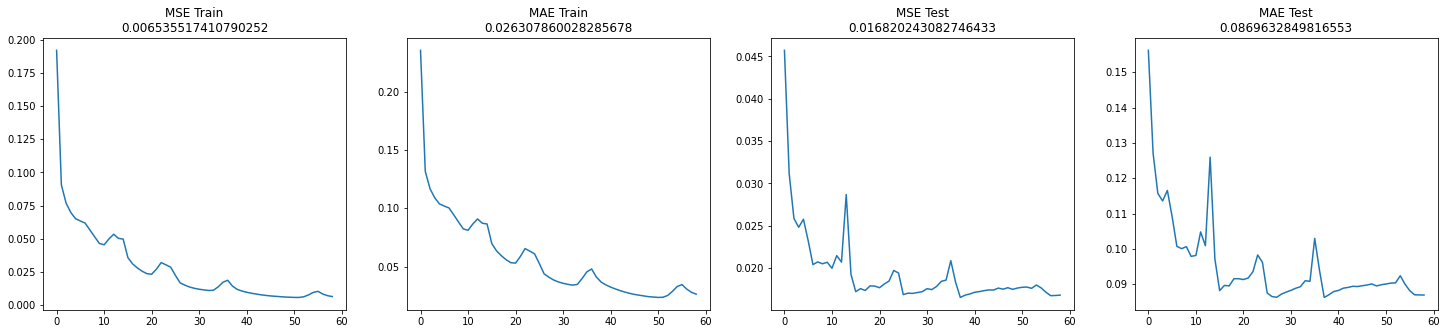

In [313]:
plt.figure(figsize=(25, 5))

ax = plt.subplot(141)
ax.plot(train_verbose_df["MSE Loss"])
ax.set_title("MSE Train\n{}".format(train_verbose_df["MSE Loss"].iloc[-1]))

ax = plt.subplot(142)
ax.plot(train_verbose_df["MAE Loss"])
ax.set_title("MAE Train\n{}".format(train_verbose_df["MAE Loss"].iloc[-1]))

ax = plt.subplot(143)
ax.plot(test_verbose_df["MSE Loss"])
ax.set_title("MSE Test\n{}".format(test_verbose_df["MSE Loss"].iloc[-1]))

ax = plt.subplot(144)
ax.plot(test_verbose_df["MAE Loss"])
ax.set_title("MAE Test\n{}".format(test_verbose_df["MAE Loss"].iloc[-1]))
plt.show()